# Building a Classifier from Lending Club Data
**An end-to-end machine learning example using Pandas and Scikit-Learn** 




## Data Ingestion



In [43]:
%matplotlib inline
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [44]:
names = [
    "funded_amnt",
    "term",
    "int_rate",             
    "emp_length",
    "home_ownership",
    "annual_inc",
    "verification_status",   
    "purpose",
    "dti",
    "delinq_2yrs",           
    "inq_last_6mths",
    "pub_rec",
    "revol_bal",
    "revol_util",
    "open_acc",
    "unemp",
    "unemp_LSFT",
    "ilc_mean",
    "ilc_LSFT",
    "gdp_mean",
    "gdp_LSFT",
    "Tbill_mean",
    "Tbill_LSFT",
    "cc_rate",
    "spread",
    "frac_loss",
]

Fnames = names[:-1]

label = names[-1]

# Open up the earlier CSV to determine how many different types ofentries there are in the column 'loan_status'
data_with_all_csv_features = pd.read_csv("./data/dfd.csv")
full_data = data_with_all_csv_features[names];
data = full_data.copy()[names]
data.head(3)

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,...,unemp_LSFT,ilc_mean,ilc_LSFT,gdp_mean,gdp_LSFT,Tbill_mean,Tbill_LSFT,cc_rate,spread,frac_loss
0,4200,36,17.27,7.0,1,50000.0,1,1,12.17,0.0,...,-0.000604,30271.15460,72.408845,58206.27465,3.738387,0.008303,0.000206,0.119133,1.808,0.536536
1,2000,36,19.05,15.0,1,81000.0,1,3,21.42,0.0,...,-0.000511,25850.40599,73.564980,50555.73682,170.150897,0.008303,0.000206,0.119133,1.808,0.958175
2,6000,36,10.16,8.0,1,94000.0,1,1,12.77,0.0,...,-0.000791,44084.32570,17.616317,177320.41480,380.902452,0.008303,0.000206,0.119133,1.808,0.699753


# Data Exploration

The very first thing to do is to explore the dataset and see what's inside. 

In [45]:
# This line drops any loan data rows with income more than $300K to remove error data
#print data.count()
print data.shape
#data = data.loc[(data['annual_inc'] <= 300000)]
##print data.shape[0]
#sdata = data.loc[(data['annual_inc'] <= 300000)]
#print sdata.shape[0]


(11440, 26)


In [46]:
#areas = full_data[['funded_amnt','term','int_rate', 'loan_status']]
#scatter_matrix(areas, alpha=0.2, figsize=(18,18), diagonal='kde')

In [47]:
#sns.set_context("poster")
#sns.countplot(x='home_ownership', hue='loan_status', data=full_data,)

In [48]:
#sns.set_context("poster")
#sns.countplot(x='emp_length', hue='loan_status', data=full_data,)

In [49]:
#sns.set_context("poster")
#sns.countplot(x='term', hue='loan_status', data=full_data,)

In [50]:
#sns.set_context("poster")
#sns.countplot(y='purpose', hue='loan_status', data=full_data,)

In [51]:
#sns.set_context("poster", font_scale=0.8)                                                  
#plt.figure(figsize=(15, 15))                                                                                                                                                                                                                                 
#plt.ylabel('Loan Originating State')
#sns.countplot(y='addr_state', hue='loan_status', data=full_data)


## Data Management 

In order to organize our data on disk, we'll need to add the following files:

- `README.md`: a markdown file containing information about the dataset and attribution. Will be exposed by the `DESCR` attribute.
- `meta.json`: a helper file that contains machine readable information about the dataset like `target_names` and `feature_names`.

In [52]:
import json 

meta = {
    'target_names': "frac_loss",
    'feature_names': list(data.columns),
    'categorical_features': {
        column: list(data[column].unique())
        for column in data.columns
        if data[column].dtype == 'object'
    },
}

with open('data/lossmeta.json', 'wb') as f:
    json.dump(meta, f, indent=2)

This code creates a `meta.json` file by inspecting the data frame that we have constructued. The `target_names` column, is just the two unique values in the `data.loan_status` series; by using the `pd.Series.unique` method - we're guarenteed to spot data errors if there are more or less than two values. The `feature_names` is simply the names of all the columns. 

Then we get tricky &mdash; we want to store the possible values of each categorical field for lookup later, but how do we know which columns are categorical and which are not? Luckily, Pandas has already done an analysis for us, and has stored the column data type, `data[column].dtype`, as either `int64` or `object`. Here I am using a dictionary comprehension to create a dictionary whose keys are the categorical columns, determined by checking the object type and comparing with `object`, and whose values are a list of unique values for that field. 

Now that we have everything we need stored on disk, we can create a `load_data` function, which will allow us to load the training and test datasets appropriately from disk and store them in a `Bunch`: 

In [53]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.datasets.base import Bunch

def load_data(root='data'):
    # Load the meta data from the file 
    with open(os.path.join(root, 'lossmeta.json'), 'r') as f:
        meta = json.load(f) 
    
    names = meta['feature_names']
    
    # Load the readme information 
    with open(os.path.join(root, 'README.md'), 'r') as f:
        readme = f.read()    
    
    X = data[Fnames]
    
    # Remove the target from the categorical features 
#    meta['categorical_features'].pop(label)
    
    y = data[label]
    
#    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2,random_state=14)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2,random_state=10)

    
    # Return the bunch with the appropriate data chunked apart
    return Bunch(
        #data = train[names[:-1]],
        data = X_train,
        #target = train[names[-1]], 
        target = y_train, 
        #data_test = test[names[:-1]], 
        data_test = X_test, 
        #target_test = test[names[-1]], 
        target_test = y_test, 
        target_names = meta['target_names'],
        feature_names = meta['feature_names'], 
        categorical_features = meta['categorical_features'], 
        DESCR = readme,
    )

dataset = load_data()
print meta['target_names']

frac_loss


In [54]:
dataset.data_test.head(5)

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,...,unemp,unemp_LSFT,ilc_mean,ilc_LSFT,gdp_mean,gdp_LSFT,Tbill_mean,Tbill_LSFT,cc_rate,spread
2242,7000,36,12.12,8.0,3,79500.0,3,2,16.69,2.0,...,0.104,-0.001681,24891.38578,91.431728,46868.98084,137.414688,0.007616,0.000209,0.119033,1.5585
7774,6250,36,13.49,5.0,1,86000.0,3,1,24.20,1.0,...,0.113,-0.000308,30388.88130,108.036406,56445.07005,170.316205,0.005246,0.000073,0.128900,3.1265
8304,11500,36,14.46,5.0,3,25200.0,1,5,13.71,0.0,...,0.121,-0.000198,29766.56507,125.020853,55693.26632,154.483850,0.005700,-0.000110,0.134367,2.8955
6851,2400,36,12.69,5.0,2,48000.0,1,11,15.28,0.0,...,0.071,-0.000379,29384.65296,66.155181,57148.16227,178.976390,0.005830,0.000191,0.123600,2.0945
2953,12000,36,15.31,7.0,3,76000.0,2,1,9.92,0.0,...,0.058,-0.000962,26730.43973,72.676547,53595.91658,122.546268,0.007457,0.000220,0.119267,1.4970


The primary work of the `load_data` function is to locate the appropriate files on disk, given a root directory that's passed in as an argument (if you saved your data in a different directory, you can modify the root to have it look in the right place). The meta data is included with the bunch, and is also used split the train and test datasets into `data` and `target` variables appropriately, such that we can pass them correctly to the Scikit-Learn `fit` and `predict` estimator methods. 

## Feature Extraction 

Now that our data management workflow is structured a bit more like Scikit-Learn, we can start to use our data to fit models. Unfortunately, the categorical values themselves are not useful for machine learning; we need a single instance table that contains _numeric values_. In order to extract this from the dataset, we'll have to use Scikit-Learn transformers to transform our input dataset into something that can be fit to a model. In particular, we'll have to do the following:

- encode the categorical labels as numeric data 
- impute missing values with data (or remove)

We will explore how to apply these transformations to our dataset, then we will create a feature extraction pipeline that we can use to build a model from the raw input data. This pipeline will apply both the imputer and the label encoders directly in front of our classifier, so that we can ensure that features are extracted appropriately in both the training and test datasets.  

### Label Encoding 

Our first step is to get our data out of the object data type land and into a numeric type, since nearly all operations we'd like to apply to our data are going to rely on numeric types. Luckily, Sckit-Learn does provide a transformer for converting categorical labels into numeric integers: [`sklearn.preprocessing.LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Unfortunately it can only transform a single vector at a time, so we'll have to adapt it in order to apply it to multiple columns. 

Like all Scikit-Learn transformers, the `LabelEncoder` has `fit` and `transform` methods (as well as a special all-in-one, `fit_transform` method) that can be used for stateful transformation of a dataset. In the case of the `LabelEncoder`, the `fit` method discovers all unique elements in the given vector, orders them lexicographically, and assigns them an integer value. These values are actually the indices of the elements inside the `LabelEncoder.classes_` attribute, which can also be used to do a reverse lookup of the class name from the integer value. 

For example, if we were to encode the `home_ownership` column of our dataset as follows:

In [55]:
from sklearn.preprocessing import LabelEncoder 

ownership = LabelEncoder() 
ownership.fit(dataset.data.home_ownership)
print(ownership.classes_)

[1 2 3 4]


In [56]:
from sklearn.preprocessing import LabelEncoder 

purpose = LabelEncoder() 
purpose.fit(dataset.data.purpose)
print(purpose.classes_)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Obviously this is very useful for a single column, and in fact the `LabelEncoder` really was intended to encode the target variable, not necessarily categorical data expected by the classifiers.

In order to create a multicolumn LabelEncoder, we'll have to extend the `TransformerMixin` in Scikit-Learn to create a transformer class of our own, then provide `fit` and `transform` methods that wrap individual `LabelEncoders` for our columns. 

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = columns 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

encoder = EncodeCategorical(dataset.categorical_features.keys())

#data = encoder.fit_transform(dataset.data)

This specialized transformer now has the ability to label encode multiple columns in a data frame, saving information about the state of the encoders. It would be trivial to add an `inverse_transform` method that accepts numeric data and converts it to labels, using the `inverse_transform` method of each individual `LabelEncoder` on a per-column basis. 

### Imputation 

Scikit-Learn provides a transformer for dealing with missing values at either the column level or at the row level in the `sklearn.preprocessing` library called the [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).

The `Imputer` requires information about what missing values are, either an integer or the string, `Nan` for `np.nan` data types, it then requires a strategy for dealing with it. For example, the `Imputer` can fill in the missing values with the mean, median, or most frequent values for each column. If provided an axis argument of 0 then columns that contain only missing data are discarded; if provided an axis argument of 1, then rows which contain only missing values raise an exception. Basic usage of the `Imputer` is as follows:

```python
imputer = Imputer(missing_values='Nan', strategy='most_frequent')
imputer.fit(dataset.data)
```

In [58]:
from sklearn.preprocessing import Imputer 

class ImputeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns = columns 
        self.imputer = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to impute. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit an imputer for each column in the data frame
        #self.imputer = Imputer(strategy='most_frequent')
        self.imputer = Imputer(strategy='mean')
        self.imputer.fit(data[self.columns])

        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        output[self.columns] = self.imputer.transform(output[self.columns])
        
        return output

imputer = ImputeCategorical(Fnames)
    
#data = imputer.fit_transform(data)

In [59]:
data.head(5)

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,...,unemp_LSFT,ilc_mean,ilc_LSFT,gdp_mean,gdp_LSFT,Tbill_mean,Tbill_LSFT,cc_rate,spread,frac_loss
0,4200,36,17.27,7.0,1,50000.0,1,1,12.17,0.0,...,-0.000604,30271.15460,72.408845,58206.27465,3.738387,0.008303,0.000206,0.119133,1.808,0.536536
1,2000,36,19.05,15.0,1,81000.0,1,3,21.42,0.0,...,-0.000511,25850.40599,73.564980,50555.73682,170.150897,0.008303,0.000206,0.119133,1.808,0.958175
2,6000,36,10.16,8.0,1,94000.0,1,1,12.77,0.0,...,-0.000791,44084.32570,17.616317,177320.41480,380.902452,0.008303,0.000206,0.119133,1.808,0.699753
3,4000,36,17.27,2.0,1,33000.0,1,2,11.78,1.0,...,-0.000742,37038.01293,104.073197,70375.20408,213.266500,0.008303,0.000206,0.119133,1.808,0.867090
4,5275,36,15.80,1.0,3,60000.0,1,2,8.62,0.0,...,-0.000742,37038.01293,104.073197,70375.20408,213.266500,0.008303,0.000206,0.119133,1.808,0.864241


Our custom imputer, like the `EncodeCategorical` transformer takes a set of columns to perform imputation on. In this case we only wrap a single `Imputer` as the `Imputer` is multicolumn &mdash; all that's required is to ensure that the correct columns are transformed. 

I had chosen to do the label encoding first, assuming that because the `Imputer` required numeric values, I'd be able to do the parsing in advance. However, after requiring a custom imputer, I'd say that it's probably best to deal with the missing values early, when they're still a specific value, rather than take a chance. 

## Model Build 

To create classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. 

# PCA

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

# we need to encode our target data as well. 

yencode = LabelEncoder().fit(dataset.target)
#print yencode

# construct the pipeline 
pca = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(Fnames)), 
        ('scalar', StandardScaler()),        
       ('classifier', PCA(n_components=20))
#        ('classifier', PCA())
    ])

# fit the pipeline 
pca.fit(dataset.data, yencode.transform(dataset.target))
#print dataset.target

Pipeline(steps=[('encoder', EncodeCategorical(columns=[])), ('imputer', ImputeCategorical(columns=['funded_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util', 'open_acc', 'unem...rue, with_mean=True, with_std=True)), ('classifier', PCA(copy=True, n_components=20, whiten=False))])

[ 14.97  26.65  35.67  42.9   48.65  53.52  58.06  62.35  66.51  70.44
  74.25  77.77  81.21  84.1   86.68  89.21  91.21  93.07  94.74  96.32]


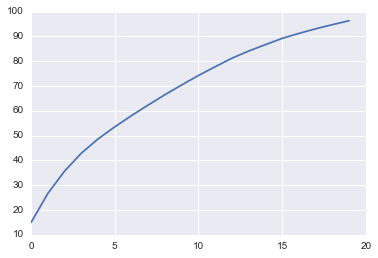

In [61]:
import numpy as np

#The amount of variance that each PC explains
var= pca.named_steps['classifier'].explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.named_steps['classifier'].explained_variance_ratio_, decimals=4)*100)

print var1
plt.plot(var1)

# Linear Regression

Fits a linear Regression model to data and makes predictions about the probability of a categorical event 

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# we need to encode our target data as well. 

yencode = LabelEncoder().fit(dataset.target)

#normalizer = Normalizer(copy=False)

# construct the pipeline 
lr = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(Fnames)), 
        ('scalar', StandardScaler()),
        #('normalizer', Normalizer(copy=False)),
        ('classifier', LinearRegression())
    ])

# fit the pipeline 
lr.fit(dataset.data, yencode.transform(dataset.target))

Pipeline(steps=[('encoder', EncodeCategorical(columns=[])), ('imputer', ImputeCategorical(columns=['funded_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util', 'open_acc', 'unem...rue)), ('classifier', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [69]:
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import collections




#TEST UNDER TEST DATASET

# encode test targets
#y_true = yencode.transform(dataset.target_test)
y_true = dataset.target_test
# use the model to get the predicted value
y_pred = lr.predict(dataset.data_test)
# execute classification report 
#print classification_report(y_true, y_pred, target_names=dataset.target_names)
# Evaluate fit of the model
print "TEST DATSET Mean Squared Error: %0.3f" % mse(y_true, y_pred)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, y_pred)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lr.score(dataset.data_test, dataset.target_test))

#TEST UNDER TRAIN DATASET
# encode test targets
#y_true = yencode.transform(dataset.target)
y_true = dataset.target
# use the model to get the predicted value
y_pred = lr.predict(dataset.data)
# execute classification report 
#print classification_report(y_true, y_pred, target_names=dataset.target_names)
print "TRAIN DATASET Mean Squared Error: %0.3f" % mse(y_true, y_pred)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, y_pred)

#TEST UNDER FULL DATASET

#lr.fit(full_data[Fnames], yencode.transform(full_data[label]))
# encode test targets
#y_true = yencode.transform(full_data[label])
y_true = full_data[label]
# use the model to get the predicted value
y_pred = lr.predict(full_data[Fnames])
# execute classification report 
#print classification_report(y_true, y_pred, target_names=dataset.target_names)
print "FULL DATASET Mean Squared Error: %0.3f" % mse(y_true, y_pred)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, y_pred)

TEST DATSET Mean Squared Error: 21346781.320
Coefficient of Determination: -341738824.015
Variance score: -341738824.02
TRAIN DATASET Mean Squared Error: 21196942.600
Coefficient of Determination: -337232855.601
FULL DATASET Mean Squared Error: 21226910.344
Coefficient of Determination: -338125883.723


# ElasticNet

ElasticNet is a linear combination of L1 and L2 regularization, meaning it combines Ridge and LASSO and essentially splits the difference.


In [77]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler

# we need to encode our target data as well. 
yencode = LabelEncoder().fit(dataset.target)


# construct the pipeline 
lelastic = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(Fnames)), 
        ('scalar', StandardScaler()),
        ('classifier', ElasticNet(alpha=0.01, l1_ratio =0.1))
    ])


# fit the pipeline 
lelastic.fit(dataset.data, yencode.transform(dataset.target))

Pipeline(steps=[('encoder', EncodeCategorical(columns=[])), ('imputer', ImputeCategorical(columns=['funded_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util', 'open_acc', 'unem...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [90]:

from sklearn.metrics import classification_report 

# encode test targets
#y_true = yencode.transform(dataset.target_test)
y_true = dataset.target_test

# use the model to get the predicted value
y_pred = lelastic.predict(dataset.data_test)

#print dataset.data_test.head(1)

# execute classification report 
#print classification_report(y_true, y_pred, target_names=dataset.target_names)
#print classification_report(y_true, y_pred, target_names=["Default","Fully Paid"])
# Evaluate fit of the model
print "Mean Squared Error: %0.3f" % mse(y_true, y_pred)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, y_pred)

Mean Squared Error: 21341030.998
Coefficient of Determination: -341646767.595


In [80]:

#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

coefs = lelastic.named_steps['classifier'].coef_
print coefs
print "Linear model:", pretty_print_linear(coefs, Fnames)


[ -35.73187834  226.37923797  303.2448814  -103.12196327   55.39987937
  -12.79386002   56.65913151  126.68824753   78.47378238   10.43284558
  222.68192694  -74.98503679  104.25645707  -96.33592355 -183.86741191
   78.3055384    97.34130382  -18.6875633   -20.94644145  -23.69878825
   34.63908193  -66.95822996 -129.3747991  -139.68525919   72.80293601]
Linear model: -35.732 * funded_amnt + 226.379 * term + 303.245 * int_rate + -103.122 * emp_length + 55.4 * home_ownership + -12.794 * annual_inc + 56.659 * verification_status + 126.688 * purpose + 78.474 * dti + 10.433 * delinq_2yrs + 222.682 * inq_last_6mths + -74.985 * pub_rec + 104.256 * revol_bal + -96.336 * revol_util + -183.867 * open_acc + 78.306 * unemp + 97.341 * unemp_LSFT + -18.688 * ilc_mean + -20.946 * ilc_LSFT + -23.699 * gdp_mean + 34.639 * gdp_LSFT + -66.958 * Tbill_mean + -129.375 * Tbill_LSFT + -139.685 * cc_rate + 72.803 * spread


# k-Nearest Neighbor

Makes predictions by locating similar instances via a similarity function or distance and averaging the majority of the most similar. 


In [75]:
# K- Neighbor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score


# we need to encode our target data as well. 

yencode = LabelEncoder().fit(dataset.target)

# construct the pipeline 
kn = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(Fnames)), 
        ('scalar', StandardScaler()),
        ('classifier', KNeighborsRegressor(n_neighbors=3))
    ])


# Next split up the data with the 'train test split' method in the Cross Validation module
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# ...and then run the 'fit' method to build a model
kn.fit(dataset.data, yencode.transform(dataset.target))


#y_true = yencode.transform(dataset.target_test)
y_true = dataset.target_test

y_pred  = kn.predict(dataset.data_test)

#print classification_report(y_true, predicted, target_names=dataset.target_names)


# Evaluate fit of the model
print "Mean Squared Error: %0.3f" % mse(y_true, y_pred)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, y_pred)

Mean Squared Error: 23096055.885
Coefficient of Determination: -369742813.270


# SVRs

Support Vector Regression (SVR) uses points in transformed problem space that separates the classes into groups.


In [99]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.svm import SVR

# we need to encode our target data as well. 

#yencode = LabelEncoder().fit(dataset.target)
yencode = dataset.target

# construct the pipeline 
svr = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(Fnames)), 
        ('scalar', StandardScaler()),
        ('classifier', SVR(kernel='linear'))
    ])





# Next split up the data with the 'train test split' method in the Cross Validation module
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# ...and then run the 'fit' method to build a model
svr.fit(dataset.data, dataset.target)


y_true = dataset.target_test

y_pred  = svr.predict(dataset.data_test)



#print classification_report(y_true, predicted, target_names=dataset.target_names)


#kernels = ['linear', 'poly', 'rbf']


#for kernel in kernels:
#    if kernel != 'poly':
#        model      = SVC(kernel=kernel)
#    else:
#        model      = SVC(kernel=kernel, degree=3)

# Evaluate fit of the model
print "Mean Squared Error: %0.3f" % mse(y_true, y_pred)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, y_pred)

Mean Squared Error: 0.062
Coefficient of Determination: 0.013


In [98]:
print y_true
print y_pred


2242     0.098197
7774     0.736762
8304     0.880838
6851     0.037479
2953     0.355358
8405     0.526315
6571     0.702082
8516     0.738103
9746     0.822114
10726    0.720508
5441     0.426134
10126    0.809698
4976     0.351530
5779     0.094443
9463     0.066560
3914     0.772281
11015    0.152887
601      0.890735
8571     0.578622
6349     0.558252
4539     0.683898
11411    0.860498
7214     0.637857
166      0.216050
5744     0.219758
7683     0.904920
1810     0.732150
285      0.726775
1619     0.482748
8518     0.167340
           ...   
7477     0.191006
11033    0.100012
5149     0.915258
10729    0.642052
7336     0.468858
4342     0.651031
9162     0.291142
10781    0.586733
612      0.916730
3810     0.824229
5489     0.342480
9506     0.493511
2330     0.885597
60       0.339127
4861     0.545675
10477    0.649450
10761    0.397398
2467     0.568351
4299     0.512640
10643    0.757804
10474    0.651635
7633     0.415262
7204     0.154404
112      0.566682
3340     0